In [1]:
# ID:sim_2 (hide)

import numpy as np # We use numpy.
np.random.seed(0) # To make this reproducible.

# Generate fake-data (simulation) (start).
n = 70 # number of observations.
alpha = 0.9 # Parameter (can be changed).
betas = np.array([-0.3, 0.7]) # Parameters (can be changed).
sigma = 0.1 # Parameter (can be changed).
m = len(betas) # Length of betas (number of variables).

xs = np.random.normal(size = (n, m)) # random matrix n x m.
# We can generalize this using a matrix multiplication.
pred = alpha + np.matmul(xs, betas)
ys = np.random.normal(scale = sigma, size = n) + pred # final output y.

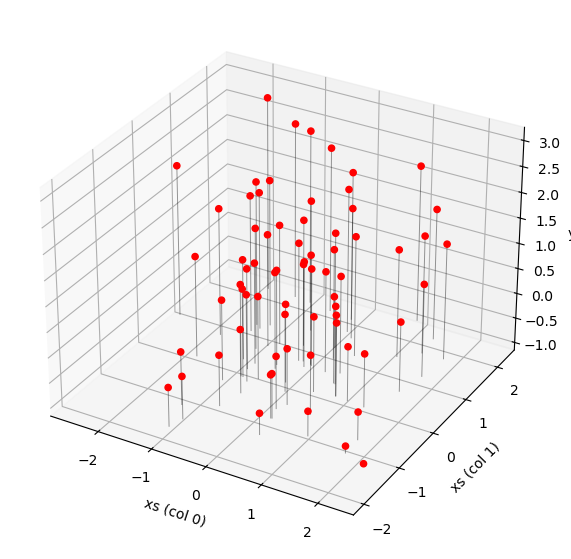

In [2]:
# OUT:sim_2
import matplotlib.pyplot as plt
# This only works when m = 2.

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('xs (col 0)')
ax.set_ylabel('xs (col 1)')
ax.set_zlabel('ys')

for i in range(n):
    ax.plot([xs[i,0], xs[i,0]], [xs[i,1], xs[i,1]], [ys[i], min(ys)], c='black', alpha=0.4, lw=0.7)

ax.scatter(xs[:,0], xs[:,1], ys, c='r', marker='o', alpha=1)

In [3]:
# ID:sklearn2 OUT:sklearn_out2 (HIDE)
# Implement the model using the scikit-learn library.
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(xs, ys) # FYI: Ugly reshape tensor removed! :-)

# Print model summary (recovered parameters):
print("Intercept (alpha): ", model.intercept_)
print("Coefficient (betas): ", model.coef_)

Intercept (alpha):  0.8927441591493339
Coefficient (betas):  [-0.31105275  0.71347268]


In [4]:
# ID:tensorflow2 OUT:tensorflow2_out (hide)
import tensorflow as tf # Using tensorflow core (hide).
# Initialize the parameters (here 'variables').
alpha = tf.Variable(0.0, dtype=tf.float32)
betas = tf.Variable(np.repeat(0.0, m), dtype=tf.float32)

xs_tf = tf.constant(xs, dtype=tf.float32) # to tensorflow (hide)...
ys_tf = tf.constant(ys, dtype=tf.float32) # to tensorflow (hide).
for i in range(1000): # Minimize 1000 steps.
    with tf.GradientTape() as tp: # Recorde gradients...
        # Define the loss (error) function on our own.
        # We need to use matvec since tf.matmul only works with 2D tensors (missing correspondence to np, this is shit).
        pred_tf = alpha + tf.linalg.matvec(xs_tf, betas)
       
        sum_squared_error = tf.reduce_sum(tf.pow(ys_tf - pred_tf, 2))
    # Minimize deriving error with respect to alpha and beta (end).
    gradients = tp.gradient(sum_squared_error, [alpha, betas])
    alpha.assign_sub(0.01 * gradients[0]) # gradient descent.
    betas.assign_sub(0.01 * gradients[1]) # gradient descent.

print("Intercept (alpha): ", alpha.numpy())
print("Coefficient (betas): ", betas.numpy())

2024-02-19 13:19:48.100728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:19:48.100804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:19:48.101656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 13:19:48.109485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 13:19:51.975092: I exter

Intercept (alpha):  0.8927441
Coefficient (betas):  [-0.31105274  0.71347266]


In [5]:
# ID:keras2 OUT:keras2_out (hide)
import keras # Using keras API (on top of tensorflow).
import keras.layers as layers

# Single layer and a single output (a linear regression) (start).
model = keras.Sequential([
        layers.Dense(units=1, input_shape=[m], activation='linear')
])
# Optimize using (stochastic) gradient descent optimizer (end).
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=1000, verbose=0)

# Print model summary (end)
print("Intercept (alpha): ", model.layers[0].get_weights()[1])
print("Coefficient (betas): ", model.layers[0].get_weights()[0])

2024-02-19 13:19:59.431878: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9da00551a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 13:19:59.431944: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-02-19 13:19:59.446078: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1708345199.490333   31342 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Intercept (alpha):  [0.8937436]
Coefficient (betas):  [[-0.31128523]
 [ 0.7142051 ]]


In [6]:
# ID:stan12 (hide)
# Using a (c++ like) DSL for model specification (hide).
stan_code = """
data {
    int<lower=0> N; // number of observations.
    int<lower=0> M; // number of columns.
    matrix[N, M] xs; // input values (matrix).
    vector[N] ys; // output values (array).
}   
parameters { // Parameters we search for.
    real alpha; 
    vector[M] beta;
    real<lower=0> sigma;
}
model { // Relationships between data and parameter.
    vector[N] pred;
    pred = alpha + xs * beta;
    ys ~ normal(pred, sigma);
}
"""

In [7]:
# ID:stan22 (hide)
import stan # Probabilistic programming language (STAN).

import nest_asyncio # (Hide)
nest_asyncio.apply() # To avoid the event loop related error (Hide)
# Run the Hamiltonian Monte Carlo (HMC) sampler to aproximate our 'error' function. Here "error" is a bit different and called the 'posterior' or '(probability) density'.
# Confusing, I know...
data = {'N': n, 'xs': xs, 'ys': ys, 'M': m}
model = stan.build(stan_code, data=data)
posterior = model.sample(num_chains=1, num_samples=4000)

Building...



Building: 28.6s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (5000/5000)
Sampling: 100% (5000/5000), done.
Messages received during sampling:
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!


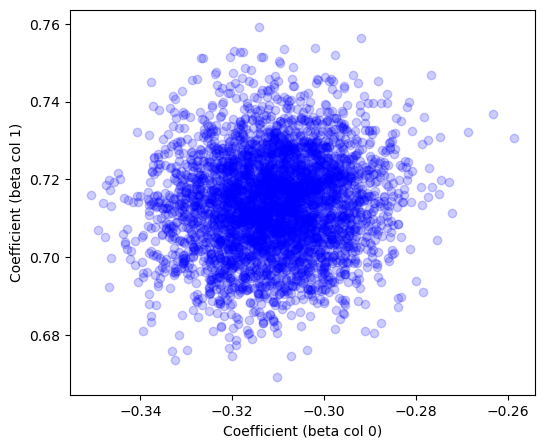

In [8]:
# OUT:stan32 (hide)
# Plotting the posterior samples.
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(posterior['beta'][0], posterior['beta'][1], marker='o', color='blue', alpha=0.2)

ax.set_xlabel('Coefficient (beta col 0)')
ax.set_ylabel('Coefficient (beta col 1)')

plt.show()

0.8500184320615232


/tmp/ipykernel_30628/1808132283.py:36: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
/tmp/ipykernel_30628/1808132283.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


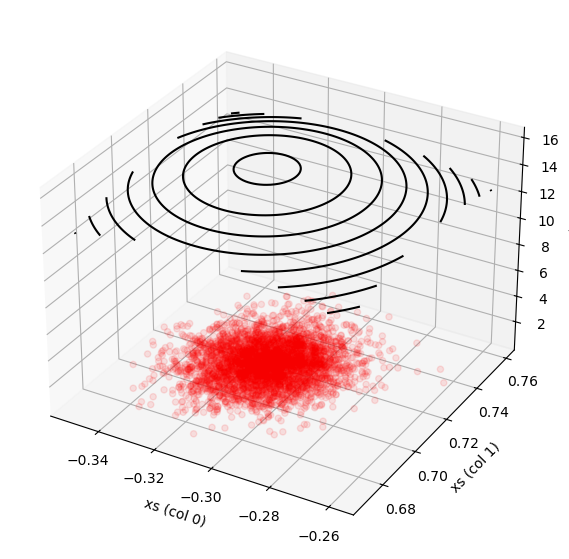

In [9]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

#%matplotlib widget
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('xs (col 0)')
ax.set_ylabel('xs (col 1)')
ax.set_zlabel('ys')

showx = posterior['beta'][0]
showy = posterior['beta'][1]
showz = posterior['alpha'][0]

X, Y, Z = kde2D(showx, showy, 0.1)

print(np.min(showz))

ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.scatter(showx, showy, showz, c='r', marker='o', alpha=0.1)

fig.show()